# Determining signal strength parameter $\mu$ with a CR measuring background normalization

## Measurement setup

Measurement with 2 regions:
- Signal region (SR)
- Control region for background normalization measurement (CR)

### Signal region (SR) containing signal and background

Number of events observed is distributed by a Poisson with parameter $b_{SR} + \mu \cdot s_{0}$ 

\begin{equation}
    N_{SR} \sim Poi\left( b_{SR} + \mu \cdot s_{0} \right)
\end{equation}

### Control region (CR)

Number of events observed is distributed by a Poisson with parameter $b_{CR}$ 

\begin{equation}
    N_{CR} \sim Poi\left( b_{CR} \right)
\end{equation}

Relation between the background component in the signal and control regions:

\begin{equation}
    b_{SR} = r \cdot b_{CR}
\end{equation}

where $r$ is assumed to be known to infinite precision.

## Model parameters

$\theta = (\mu, b_{CR})$

- POI: $\mu$
- NP: $b_{CR}$

## Test statistic

\begin{equation}
    t
    =
    -2 \log \frac{\mathcal{L} (\mu, \hat{\hat{\nu}} )}{ \mathcal{L}(\hat{\mu}, \hat{\nu}) }
\end{equation}

In [87]:
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

Utility functions

In [25]:
def likelihood_poi(mu, n, bkg, s0=1.0, neg=False, log=False):
    """Return the value of the Poisson likelihood function, given the:
       - mu: signal strength parameter,
       - n: number of events observed,
       - bkg: expected number of background events,
       - s0: nominal number of signal events
       The total expected number of events is lambda = bkg + mu*s0.
       
       The `neg` argument just multiplies the likelihood by (-1).
       This is used for the minimize() function."""
    sig = mu * s0
    N_exp = bkg + sig
    if log:
        likelihood = poisson.pmf(n, mu=N_exp)
    else:
        likelihood = poisson.logpmf(n, mu=N_exp)
    
    if neg:
        return -likelihood
    return likelihood

In [92]:
def model_likelihood(parameters, SR_measured, CR_measured, s0=1.0, r=0.2, log=False, neg=False):
    
    mu   = parameters[0]
    b_CR = parameters[1]
    
    b_SR = b_CR*r
    
    if log:
        likelihood_SR = likelihood_poi(mu=mu, n=SR_measured, bkg=b_SR, log=True)
        likelihood_CR = poisson.logpmf(CR_measured, mu=b_CR)
        model_likelihood = likelihood_SR+likelihood_CR
    else:
        likelihood_SR = likelihood_poi(mu=mu, n=SR_measured, bkg=b_SR, log=False)
        likelihood_CR = poisson.pmf(CR_measured, mu=b_CR)
        model_likelihood = likelihood_SR*likelihood_CR
    if neg:
        return -model_likelihood
    else:
        return model_likelihood

## Truth model

In [93]:
nExperiments = 1000

In [94]:
Z = 1.64
s0 = 1.0

In [95]:
b_SR_truth = 1000.0

In [96]:
b_CR_truth = 5000.0

In [97]:
r = b_SR_truth/b_CR_truth

## Hypotheses

### Null hypothesis $H_{0}$: There is only background in the SR

$H_{0}$ hypothesis parameters

SR

In [37]:
b_SR_H0   = 1000.0
s_SR_H0   = 0.0
SR_exp_H0 = b_SR_H0 + s_SR_H0
mup_H0    = s_SR_H0/s0

In [38]:
SR_events_H0 = poisson.rvs(mu=SR_exp_H0, loc=0.0, size=nExperiments)

CR

In [41]:
b_CR_exp_H0 = 5000.0

In [42]:
CR_events_H0 = poisson.rvs(mu=b_CR_exp_H0, loc=0.0, size=nExperiments)

### Alternative hypothesis $H_{1}$

$H_{1}$ hypothesis parameters

SR

In [60]:
b_SR_H1   = 1000.0
s_SR_H1   = 50
SR_exp_H1 = b_SR_H1 + s_SR_H1
mup_H1    = s_SR_H1/s0

In [61]:
SR_events_H1 = poisson.rvs(mu=SR_exp_H1, loc=0.0, size=nExperiments)

CR

In [62]:
b_CR_exp_H1 = 5000.0

In [63]:
CR_events_H1 = poisson.rvs(mu=b_CR_exp_H0, loc=0.0, size=nExperiments)

----

Text(0,0.5,'Frequency')

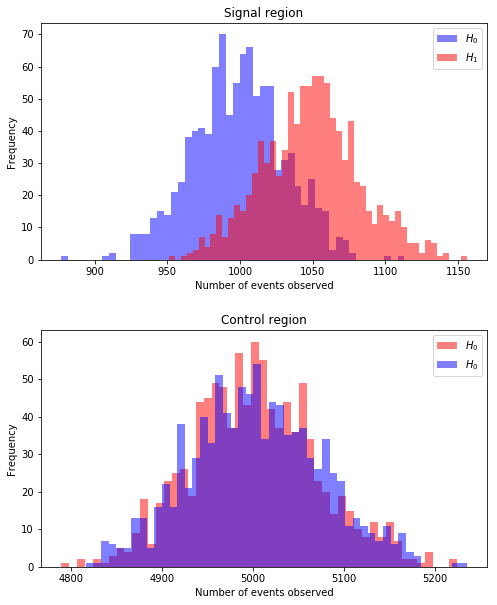

In [77]:
fig,axes = plt.subplots(nrows=2, figsize=(8,10))
fig.subplots_adjust(hspace=0.3)
ax = axes.flatten()
ax[0].hist(SR_events_H0, bins=50, color='b', alpha=0.5, label=r'$H_{0}$')
ax[0].hist(SR_events_H1, bins=50, color='r', alpha=0.5, label=r'$H_{1}$')
ax[0].set_title("Signal region")
ax[0].set_xlabel("Number of events observed")
ax[0].set_ylabel("Frequency")
ax[0].legend()
ax[1].hist(CR_events_H0, bins=50, color='r', alpha=0.5, label=r'$H_{0}$');
ax[1].hist(CR_events_H1, bins=50, color='b', alpha=0.5, label=r'$H_{0}$');
ax[1].set_title("Control region")
ax[1].legend()
ax[1].set_xlabel("Number of events observed")
ax[1].set_ylabel("Frequency")

In [98]:
model_likelihood([10.0, 5000.0], SR_events_H0, CR_events_H0)

array([-0.03046161, -0.02358773, -0.01488374, -0.03577926, -0.02293778,
       -0.00253098, -0.01991023, -0.00340571, -0.03265162, -0.00323156,
       -0.03109497, -0.0388508 , -0.02209228, -0.02181345, -0.0260511 ,
       -0.02598358, -0.02451212, -0.02622144, -0.01844899, -0.02529295,
       -0.03506165, -0.02537287, -0.01051438, -0.02297144, -0.00297553,
       -0.01077057, -0.00866349, -0.02387757, -0.01729794, -0.02195174,
       -0.04252777, -0.01858933, -0.02411278, -0.01206195, -0.02443001,
       -0.00994402, -0.00258873, -0.02148585, -0.03376504, -0.02881424,
       -0.01216871, -0.01988231, -0.01621746, -0.02481185, -0.01306654,
       -0.02254959, -0.008729  , -0.00321865, -0.00946012, -0.03763478,
       -0.03318175, -0.0042559 , -0.02261149, -0.01334946, -0.01192602,
       -0.00384224, -0.02714371, -0.01986284, -0.01048345, -0.02316299,
       -0.00522662, -0.01911663, -0.01545385, -0.02452754, -0.02620943,
       -0.04508603, -0.02504183, -0.02249351, -0.01910161, -0.02

In [99]:
def calc_parameter_MLE(NLL, SR, CR):
    res = minimize(NLL, x0=[1.0, 5000.0], args=(SR, CR, 1.0, r, True, True), method='Nelder-Mead')
    LL  = -res['fun']
    parameter_MLE = res['x']
    return parameter_MLE

In [100]:
parameters_H0 = [calc_parameter_MLE(model_likelihood, SR, CR) for SR, CR in zip(SR_events_H0, CR_events_H0)]
parameters_H1 = [calc_parameter_MLE(model_likelihood, SR, CR) for SR, CR in zip(SR_events_H1, CR_events_H1)]

In [101]:
parameters_H0 = np.array(parameters_H0)
parameters_H1 = np.array(parameters_H1)

## Distribution of $\hat{\mu},\hat{b}_{CR}$

Text(0.5,1,'Best fit $(\\hat{\\mu},\\hat{b}_{CR})$')

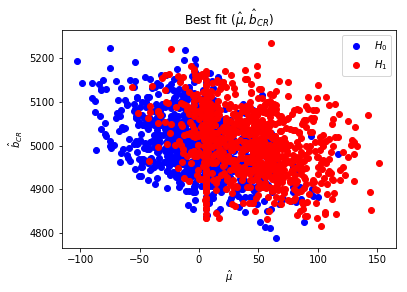

In [107]:
f,ax = plt.subplots()
ax.scatter(parameters_H0[:,0], parameters_H0[:,1], c='b', label=r"$H_{0}$")
ax.scatter(parameters_H1[:,0], parameters_H1[:,1], c='r', label=r"$H_{1}$")
ax.set_xlabel(r'$\hat{\mu}$')
ax.set_ylabel(r'$\hat{b}_{CR}$')
ax.legend()
ax.set_title(r"Best fit $(\hat{\mu},\hat{b}_{CR})$")

In [105]:
np.corrcoef(parameters_H0[:,0], parameters_H0[:,1])

array([[ 1.        , -0.44417945],
       [-0.44417945,  1.        ]])

## Distribution of $t$